# Synthesize a Table (CTGAN)

In this notebook, we'll use the SDV to create synthetic data for a single table and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **CTGAN** algorithm to do this. CTGAN uses generative adversarial networks (GANs) to create synthesize data with high fidelity.

# Installation and support functions

Install the SDV library.

In [1]:
%pip install sdv anonymeter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.4 MB/s eta 0:00:00


All of the experiments were carried out on the Adults dataset provided by the authors of the Anonymeter paper. They are not the original creators of the dataset. However, they provide it alongside a set of synthetic data which can be used for quick demos for the Anonymeter library. Another benefit of the dataset is that it comes split into two, which is a necessary step for using GANs. It is important to withold a part of the original dataset to prevent overfitting (??).

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

base_path = "drive/MyDrive/Colab Notebooks/" # Please make sure to set a local
                                             # base_path. Google drive was used
                                             # for persistence.

bucket_url = "https://storage.googleapis.com/statice-public/anonymeter-datasets/"
train = pd.read_csv(os.path.join(bucket_url, "adults_train.csv"))
synthetic = pd.read_csv(os.path.join(bucket_url, "adults_syn_ctgan.csv"))
real_data = pd.read_csv(os.path.join(bucket_url, "adults_control.csv"))
metadata = SingleTableMetadata()

metadata.detect_from_dataframe(data=train)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart Runtime`

## Introduce `anonymeter` evaluation functions.
These functions handle evaluation for the three attacks supported by anonymeter. They accept three inputs `ori`, `synth`, `control` which are pandas DataFrams containing data entries. The functions then load the necessary evaluator with parameters outlined in the anonymeter tutorial and run the attacks.

The functions are based on the demo provided by the Anonymeter authors.

In [ ]:
from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

from sdv.evaluation.single_table import evaluate_quality

n_attacks=1000

def measure_quality(synth, control, meta):
  return evaluate_quality(
      control,
      synth,
      meta
  )

def measure_singling_out(ori, synth, control, mode):
    evaluator = SinglingOutEvaluator(
      ori=ori,
      syn=synth,
      control=control,
      n_attacks=n_attacks
    )

    try:
      evaluator.evaluate(mode)

      res = evaluator.results()

      return res

    except RuntimeError as ex:
      print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")


def measure_linkability(ori, synth, control, aux_cols):

    evaluator = LinkabilityEvaluator(ori=ori,
                                 syn=synth,
                                 control=control,
                                 aux_cols=aux_cols,
                                 n_attacks=n_attacks)

    evaluator.evaluate(n_jobs=-2)

    res = evaluator.results()

    return res

def measure_inference(ori, synth, control, aux_cols):

    columns = ori.columns
    results = []

    for secret in columns:

        aux_cols = [col for col in columns if col != secret]

        evaluator = InferenceEvaluator(ori=ori,
                                   syn=synth,
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=n_attacks)

        evaluator.evaluate(n_jobs=-2)

        results.append((secret, evaluator.results()))

    return results


`get_results` collects the synthesizer quality and univariate singling out, linkability, and inference risks. Due to time constraints, multivariate singling out is not collected as it is significantly slower. Additionally due to the fact that the singling out evaluator can fail, the `results` object is saved locally at the end of iteration.

The function is ran 30 times to provide an ample amount of results.

In [ ]:
def run_metrics(fileName):
    aux_cols = [
      ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
      [ 'race', 'sex', 'fnlwgt', 'age', 'country']
    ]

    synthesizer = CTGANSynthesizer.load(fileName)
    synthetic_data = synthesizer.sample(num_rows=len(real_data))

    quality = measure_quality(synthetic_data, real_data, metadata)
    singling_uni_res = measure_singling_out(train,
                                            synthetic_data,
                                            real_data,
                                            "univariate")

    linkability_res = measure_linkability(train,
                                          synthetic_data,
                                          real_data,
                                          aux_cols)

    inference_risks = measure_inference(train,
                                        synthetic_data,
                                        real_data,
                                        aux_cols)

    return (quality,
            singling_uni_res,
            linkability_res,
            inference_risks)

def get_results(model_list):
  result = []

  for name, fileName in model_list:

      quality, singling_uni_res, linkability_res, inference_risks = run_metrics(fileName)

      result.append(
          (name,
           quality,
           singling_uni_res,
           linkability_res,
           inference_risks)
          )

  return result

def collect_results(model_list, resFileName = "results"):
  results = []
  base_num_tests = 30

  try:
    with open(f"{base_path}{resFileName}.pkl", 'rb') as file:
      results = pickle.load(file)
  except FileNotFoundError:
    print("Results back up not found, starting from the beginning")

  num_tests = base_num_tests - len(results)

  for i in range(num_tests):
    results.append(get_results(model_list))
    print(f"Finished test round {len(results)}")

    with open(f'{base_path}{resFileName}.pkl', 'wb') as file:
      pickle.dump(results, file)

The results object is processed and turned into a DataFrame that summarizes the findings of the experiments.

In [ ]:
def process_results(resFileName = "results"):
  with open(f"{base_path}{resFileName}.pkl", 'rb') as file:
      results = pickle.load(file)

  df=pd.DataFrame(results)

  final_breakdown = []

  def get_quality_score(report):
    return report.get_score() * 100

  def get_success(evaluator):
    return int(evaluator.attack_rate > evaluator.baseline_rate)

  def get_evaluator(infer_tuple):
    col, evaluator = infer_tuple

    return evaluator

  def process_inference_risk(privacy_list):
    success = list(map(get_success, list(map(get_evaluator, privacy_list))))

    return success

  for column in df:
    col_df = pd.DataFrame(df[column].to_list())

    batch_size = col_df[0][0]
    quality_reports = np.array(list(map(get_quality_score, col_df[1])))
    singling_out_risk = np.array(list(map(get_success, col_df[2].dropna())))
    linkability_risk = np.array(list(map(get_success, col_df[3])))
    inference_risk = np.array(list(map(process_inference_risk, col_df[4]))).flatten()

    final_breakdown.append((batch_size,
                          np.mean(quality_reports),
                          (singling_out_risk.sum() / len(singling_out_risk)) * 100,
                          (linkability_risk.sum() / len(linkability_risk)) * 100,
                          (inference_risk.sum() / (len(inference_risk))) * 100,
                          ))


  results_table = pd.DataFrame(final_breakdown, columns=['Batch Size',
                                                         'Quality',
                                                         'Singling Out Success',
                                                         'Linkability Success',
                                                         'Inference Success'
                                                         ]
                               )
  return results_table

# 1. Testing `batch_size`
In this section, I carry out tests to determine an appropriate batch size for privacy maximization. In general, higher batch sizes lead to more generalization, as the GAN works on larger samples. This should provide security benefits as a more general set would obscure qualities about the dataset that can be abused. However, as you can see from the results, it seems that there is little privacy different, as measured by Anonymeter, between the selected batch sizes. These results could be due to the testing set up, as only a limited amount of batch sizes were used due to time constraints. Furthermore, the authors of the Anonymeter paper found that the `Adults` dataset, which is used for this assignment, provides a high degree of privacy on its own.  


In the future, it would benefit to employ different hyperparameter techniques, such as random search, to determine an optimal batch size. Another avenue for future research is swapping out the `Adults` dataset for one with less secure data.

The batches used for this experiment are educated guesses based on papers about GANs. 500 is the base batch size for CTGAN and provides a good baseline.

In [ ]:
batches = [1500, 1000, 500, 250, 50]

models = []

for batch in batches:
    models.append(f"{base_path}synthesizer_batch_{batch}.pkl")

batch_models = list(zip(batches, models)) # zip the file names and batch sizes to make model building slightly easier

## Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [ ]:
for batch, fileName in batch_models:
  synthesizer = CTGANSynthesizer(
      metadata=metadata,
      batch_size=batch,
      verbose=True
  )
  synthesizer.fit(train)

  synthesizer.save(fileName)


<font color="maroon"><i><b>This step takes a few minutes.</b> For larger datasets, this phase may take longer. A drawback of a GAN-based model like CTGAN is performance.</i></font>

In [ ]:
collect_results(batch_models)

process_results()

,Batch Size,Quality,Singling Out Success,Linkability Success,Inference Success
0,1500,84.473872,100.0,13.333333,92.888889
1,1000,82.861517,100.0,20.000000,92.666667
2,500,82.996437,100.0,3.333333,86.888889
3,250,85.551017,100.0,13.333333,93.555556
4,50,83.382296,100.0,6.666667,90.888889


# 2 Comparing CTGAN and GaussianCopulaSynthesizer in terms of performance benefit
Use the `sample` function and pass in any number of rows to synthesize.

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer

models = []

gaus_synthesizer = GaussianCopulaSynthesizer(metadata)
gaus_synthesizer.fit(train)
gaus_synthesizer.save(f"{base_path}gaussian.pkl")
models.append(("gaussian", f"{base_path}gaussian.pkl"))

GAN_synthesizer = CTGANSynthesizer(
    metadata=metadata,
    verbose=True
)
GAN_synthesizer.fit(train)
GAN_synthesizer.save(f"{base_path}gan_synth.pkl")
models.append(("CTGAN", f"{base_path}gan_synth.pkl"))


In [ ]:
# collect_results(models, resFileName="model_comparison")

process_results(resFileName="model_comparison")

,Batch Size,Quality,Singling Out Success,Linkability Success,Inference Success
0,gaussian,79.416864,100.0,6.666667,70.888889
1,CTGAN,86.621442,100.0,13.333333,93.555556


The synthesizer is generating synthetic guests in the **same format as the original data**.

# 3 Performance testing (maybe)

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

In [4]:
import time

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

from sdv.evaluation.single_table import evaluate_quality

def measure_singling_out_time(ori, synth, control, mode, n_a):
  start = time.time()
  evaluator = SinglingOutEvaluator(
    ori=ori,
    syn=synth,
    control=control,
    n_attacks=n_a
  )

  try:
    evaluator.evaluate(mode)
    end = time.time()

    return start - end

  except RuntimeError as ex:
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
        "For more stable results increase `n_attacks`. Note that this will "
        "make the evaluation slower.")

    return start - end


def measure_linkability_time(ori, synth, control, aux_cols, n_a):
  start = time.time()

  evaluator = LinkabilityEvaluator(ori=ori,
                               syn=synth,
                               control=control,
                               aux_cols=aux_cols,
                               n_attacks=n_a)

  evaluator.evaluate(n_jobs=-2)
  end = time.time()

  return start - end

def measure_inference_time(ori, synth, control, aux_cols, n_a):
  start = time.time()

  columns = ori.columns
  results = []

  for secret in columns:
      aux_cols = [col for col in columns if col != secret]

      evaluator = InferenceEvaluator(ori=ori,
                                 syn=synth,
                                 control=control,
                                 aux_cols=aux_cols,
                                 secret=secret,
                                 n_attacks=n_a)

      evaluator.evaluate(n_jobs=-2)
      end = time.time()

      results.append(start - end)

  return results

In [6]:
def run_time_metrics(n_a):
    aux_cols = [
      ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
      [ 'race', 'sex', 'fnlwgt', 'age', 'country']
    ]

    singling_uni_time = measure_singling_out_time(train,
                                                  synthetic,
                                                  real_data,
                                                  "univariate",
                                                  n_a)


    linkabilit_time = measure_linkability_time(train,
                                               synthetic,
                                               real_data,
                                               aux_cols,
                                               n_a)

    inference_time = measure_inference_time(train,
                                            synthetic,
                                            real_data,
                                            aux_cols,
                                            n_a)

    return (singling_uni_time,
            linkabilit_time,
            inference_time)

def get_time_results(n_a_values):
  result = []

  for n_a in n_a_values:

      singling_uni_time, linkability_time, inference_time = run_time_metrics(n_a)

      result.append(
          (n_a,
           singling_uni_time,
           linkability_time,
           inference_time)
          )

  return result

def collect_time_results(n_a_values, resFileName = "results"):
  results = []
  base_num_tests = 10

  try:
    with open(f"{base_path}{resFileName}.pkl", 'rb') as file:
      results = pickle.load(file)
  except FileNotFoundError:
    print("Results back up not found, starting from the beginning")

  num_tests = base_num_tests - len(results)

  for i in range(num_tests):
    results.append(get_time_results(n_a_values))
    print(f"Finished test round {len(results)}")

    with open(f'{base_path}{resFileName}.pkl', 'wb') as file:
      pickle.dump(results, file)

# n_a_values = [2000, 1000, 500, 250, 100]

# collect_time_results(n_a_values, "time_results")

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


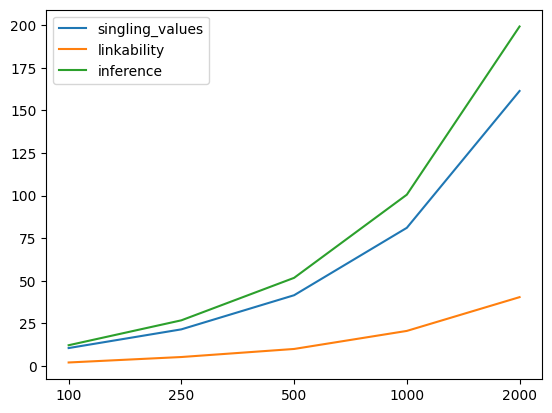

In [103]:
def process_time_results(resFileName = "results"):
  with open(f"{base_path}{resFileName}.pkl", 'rb') as file:
      results = pickle.load(file)

  df=pd.DataFrame(results)

  final_breakdown = []


  # def get_quality_score(report):
  #   return report.get_score() * 100

  # def get_success(evaluator):
  #   return int(evaluator.attack_rate > evaluator.baseline_rate)

  # def get_evaluator(infer_tuple):
  #   col, evaluator = infer_tuple

  #   return evaluator

  # def process_inference_risk(privacy_list):
  #   success = list(map(get_success, list(map(get_evaluator, privacy_list))))

  #   return success

  for column in df:
    col_df = pd.DataFrame(df[column].to_list())

    num_attacks = col_df[0][0]

    print(type(col_df[3]))

    singling_times = np.array(list(map(abs, col_df[1].dropna())))
    linkability_times = np.array(list(map(abs, col_df[2].dropna())))
    inference_risk = np.array(list(map(abs, col_df[3].explode().dropna())))

    final_breakdown.append((num_attacks,
                          singling_times.mean(),
                          linkability_times.mean(),
                          inference_risk.mean()
                          ))

  final_breakdown = sorted(final_breakdown)
  attacks = [i[0] for i in final_breakdown]
  attacksi = list(range(len(attacks)))
  values = [i[1:] for i in final_breakdown]

  singling_values = [i[1] for i in final_breakdown]
  linkability = [i[2] for i in final_breakdown]
  inference = [i[3] for i in final_breakdown]

  line1, = plt.plot(attacksi, singling_values, label="singling_values")
  line2, = plt.plot(attacksi, linkability, label="linkability")
  line3, = plt.plot(attacksi, inference, label="inference")
  # line2, = plt.plot(final_breakdown[1], label=attacks[1])
  # line3, = plt.plot(final_breakdown[2], label=attacks[2])
  # line4, = plt.plot(final_breakdown[3], label=attacks[3])
  # line5, = plt.plot(final_breakdown[4], label=attacks[4])

  plt.xticks(attacksi, attacks)
  plt.legend(handles=[line1, line2, line3])

  plt.show()
process_time_results("time_results")

In [15]:
n_a_values = [2000, 1000, 500, 250, 100]

collect_time_results(n_a_values, "time_results")

process_time_results("time_results")

2000
1000
500
250
100


# 2.4 Evaluating Real vs. Synthetic Data
The synthetic data replicates the **mathematical properties** of the real data. To get more insight, we can use the `evaluation` module.

In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

The report allows us to visualize the different properties that were captured. For example, the visualization below shows us _which_ individual column shapes were well-captured and which weren't.

In [ ]:
quality_report.get_visualization('Column Pair Trends')

# 2.5 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='age',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.